In [16]:
# ---------------------------------------------------------------
#   ML PIPELINE FOR WINE QUALITY (COMBINED FULL + TUNED MODELS)
#   WITH FULL EDA SECTION INSERTED
# ---------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score,
    RandomizedSearchCV
)
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

In [17]:
# ---------------------------------------------------------------
# 1. DATA LOADING
# ---------------------------------------------------------------

print("\n--- 1. DATA LOADING & EXPLORATION ---")

try:
    data = pd.read_csv("/content/WineQT.csv")
except FileNotFoundError:
    print("Error: WineQT.csv not found.")
    exit()

print(f"Shape: {data.shape}")
print(data.head())
print("Missing Values:\n", data.isnull().sum())

df = data.copy()  # For EDA usage consistency


--- 1. DATA LOADING & EXPLORATION ---
Shape: (1143, 13)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0  

In [18]:

# ---------------------------------------------------------------
# 1B. FULL EDA SECTION (YOUR NEWLY ADDED CODE)
# ---------------------------------------------------------------

print("\n--- 1B. EXPLORATORY DATA ANALYSIS (EDA) ---")


--- 1B. EXPLORATORY DATA ANALYSIS (EDA) ---


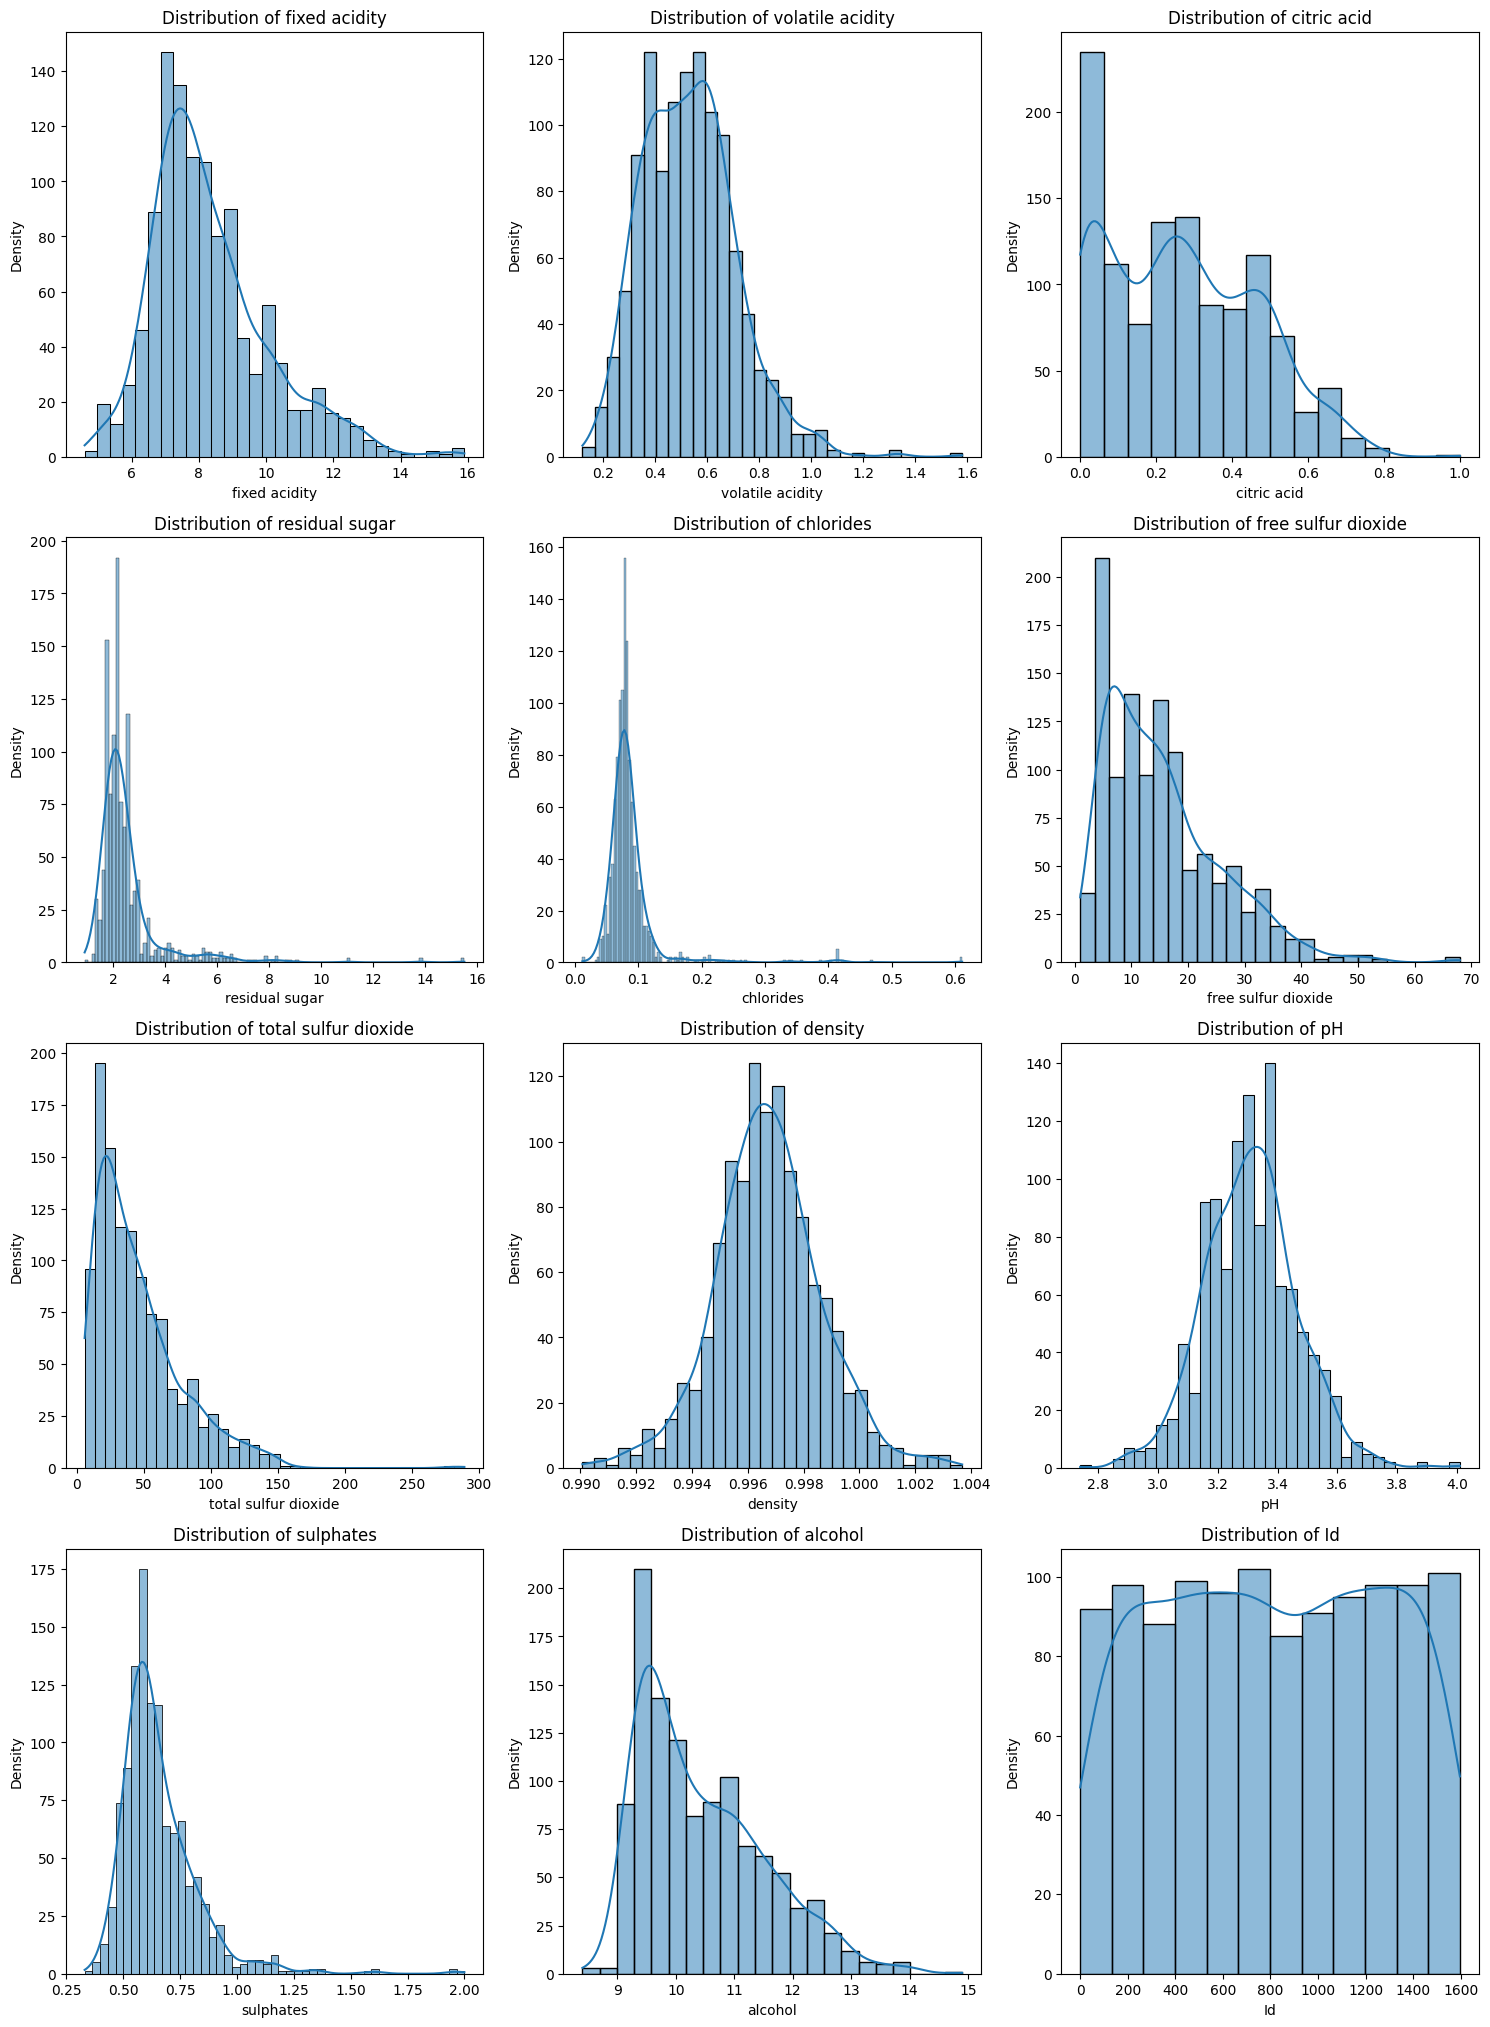


Histograms with KDE generated for all features.


In [19]:

# =============================
# HISTOGRAMS WITH KDE
# =============================
num_features = df.columns.drop("quality")

plt.figure(figsize=(15, 25))
for i, feature in enumerate(num_features):
    plt.subplot(len(num_features)//3 + 1, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.tight_layout()
plt.show()

print("\nHistograms with KDE generated for all features.")


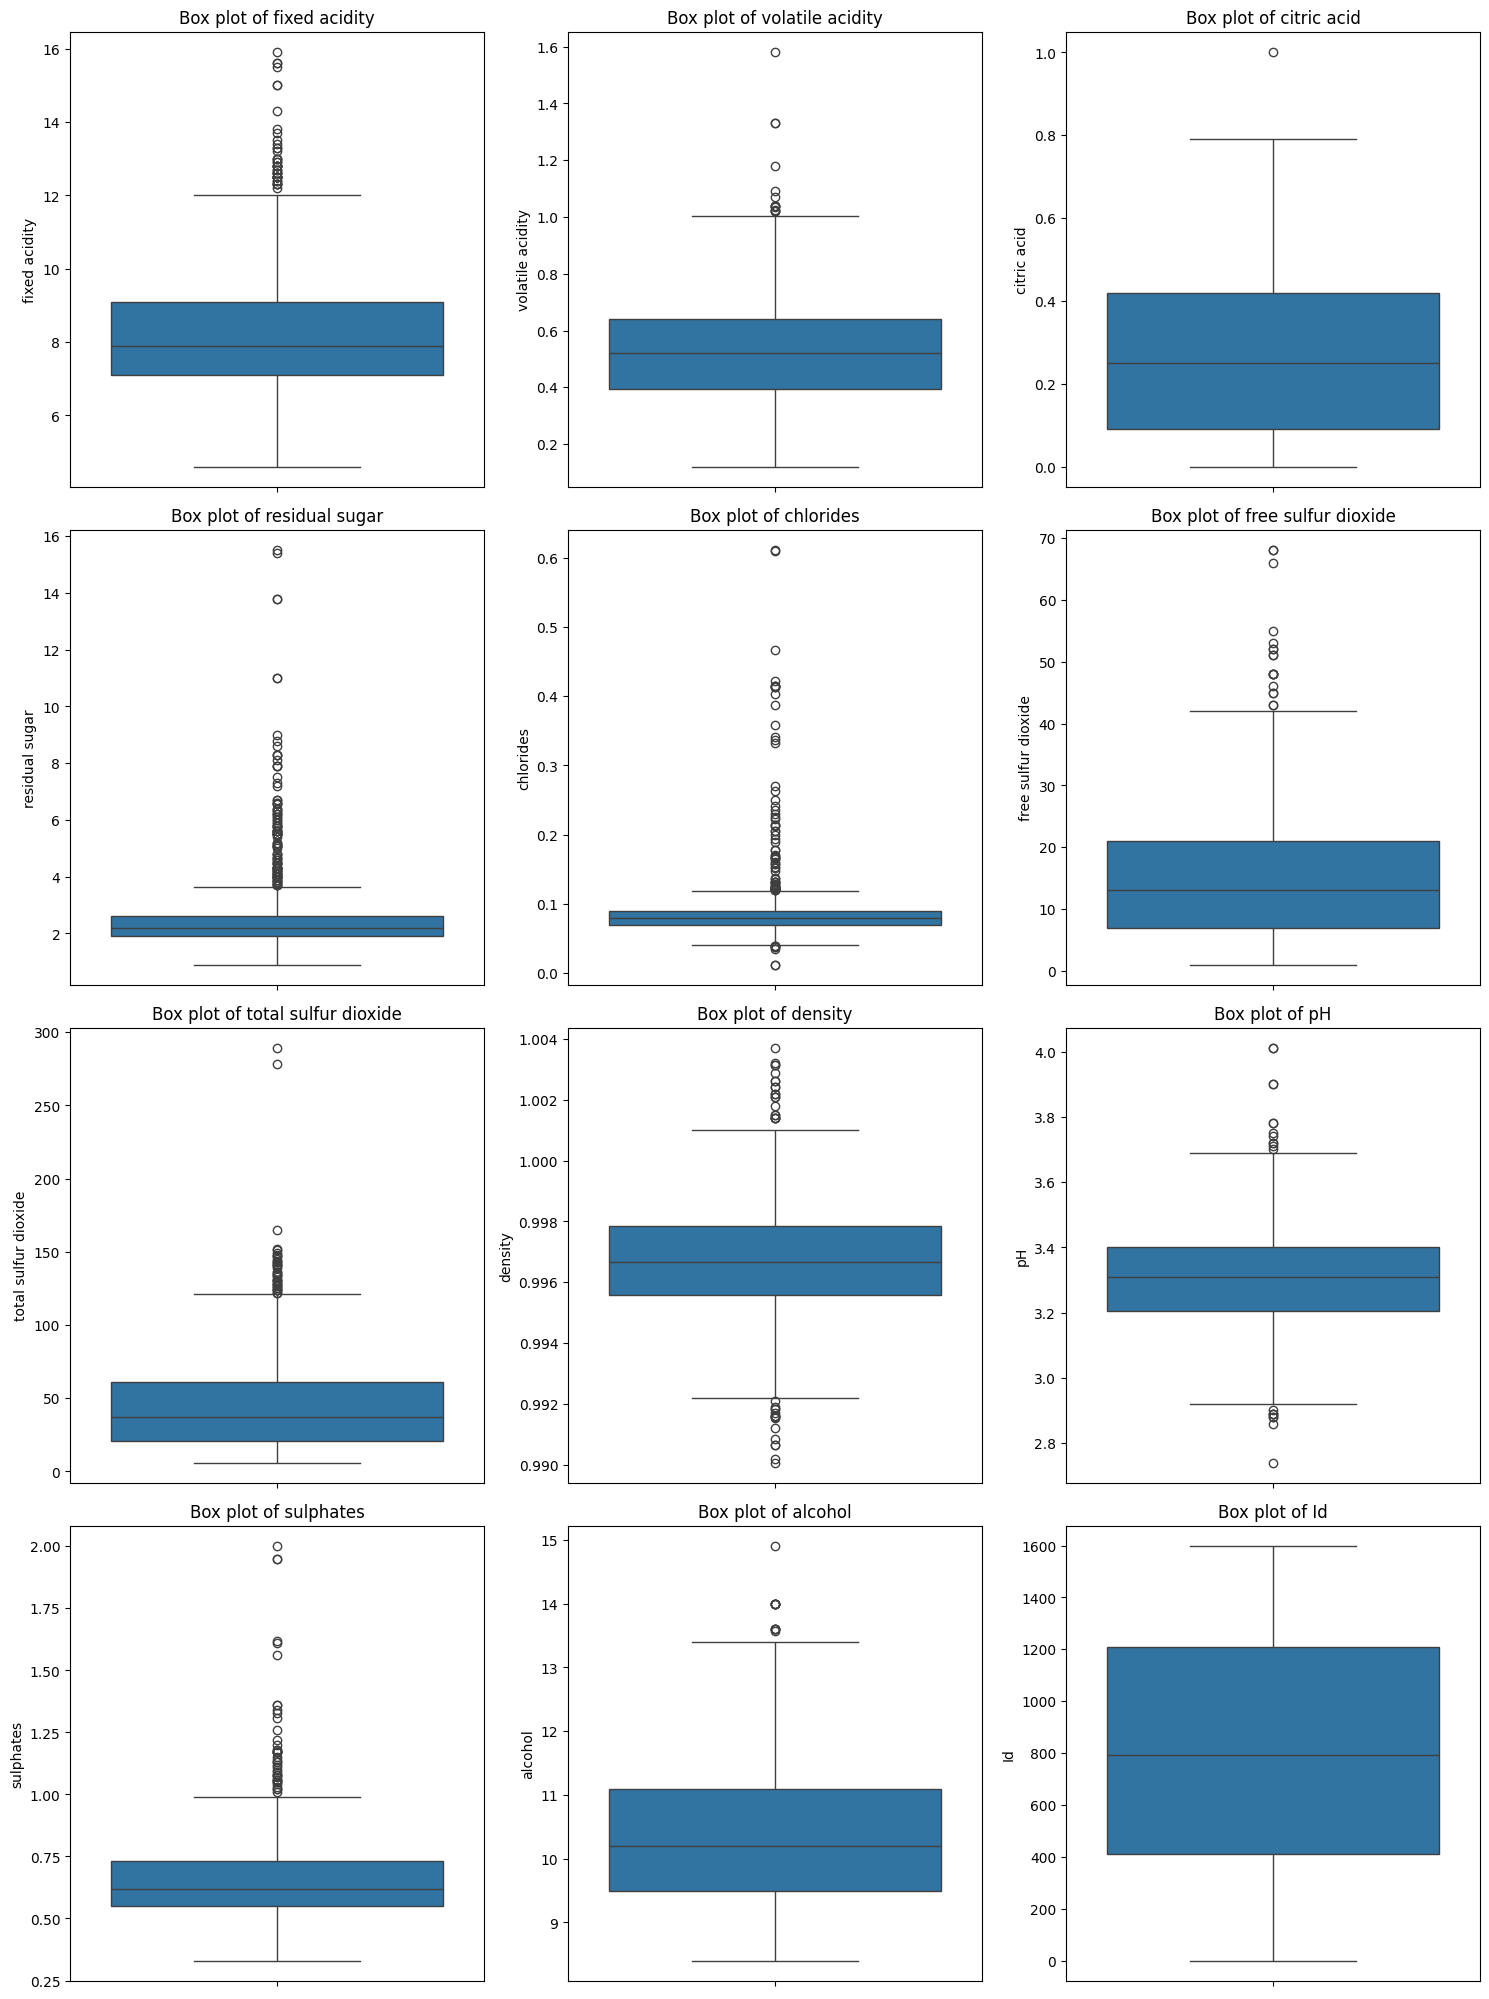

Boxplots for all numerical features generated.


In [20]:

# =============================
# BOXPLOTS FOR OUTLIERS
# =============================
plt.figure(figsize=(15, 25))
for i, feature in enumerate(num_features):
    plt.subplot(len(num_features)//3 + 1, 3, i+1)
    sns.boxplot(y=df[feature])
    plt.title(f'Box plot of {feature}')
    plt.tight_layout()
plt.show()

print("Boxplots for all numerical features generated.")

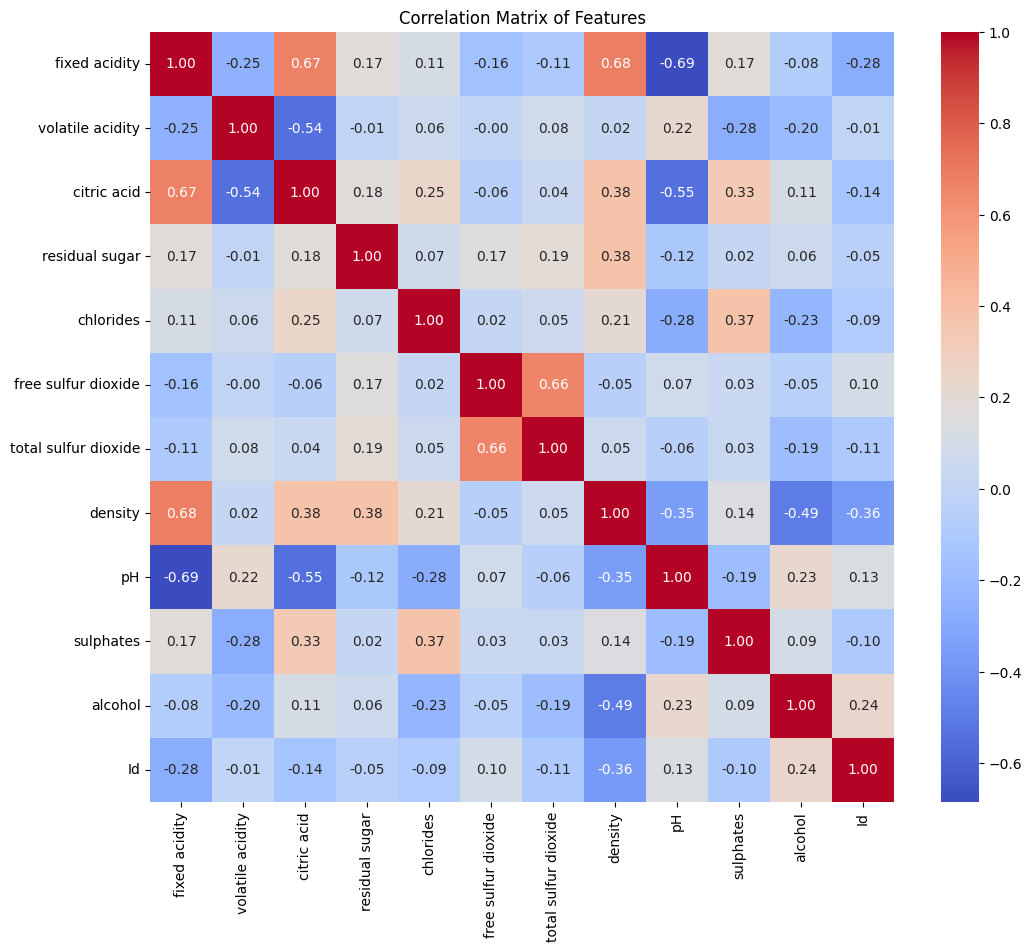


Correlations with target variable:
fixed acidity           0.121970
volatile acidity       -0.407394
citric acid             0.240821
residual sugar          0.022002
chlorides              -0.124085
free sulfur dioxide    -0.063260
total sulfur dioxide   -0.183339
density                -0.175208
pH                     -0.052453
sulphates               0.257710
alcohol                 0.484866
Id                      0.069708
Name: quality, dtype: float64


In [21]:
# =============================
# CORRELATION MATRIX
# =============================
correlation_matrix_X = df[num_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_X, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# Combine X + y for target correlation
correlations_with_target = df.corr()['quality'].drop('quality')

print("\nCorrelations with target variable:")
print(correlations_with_target)

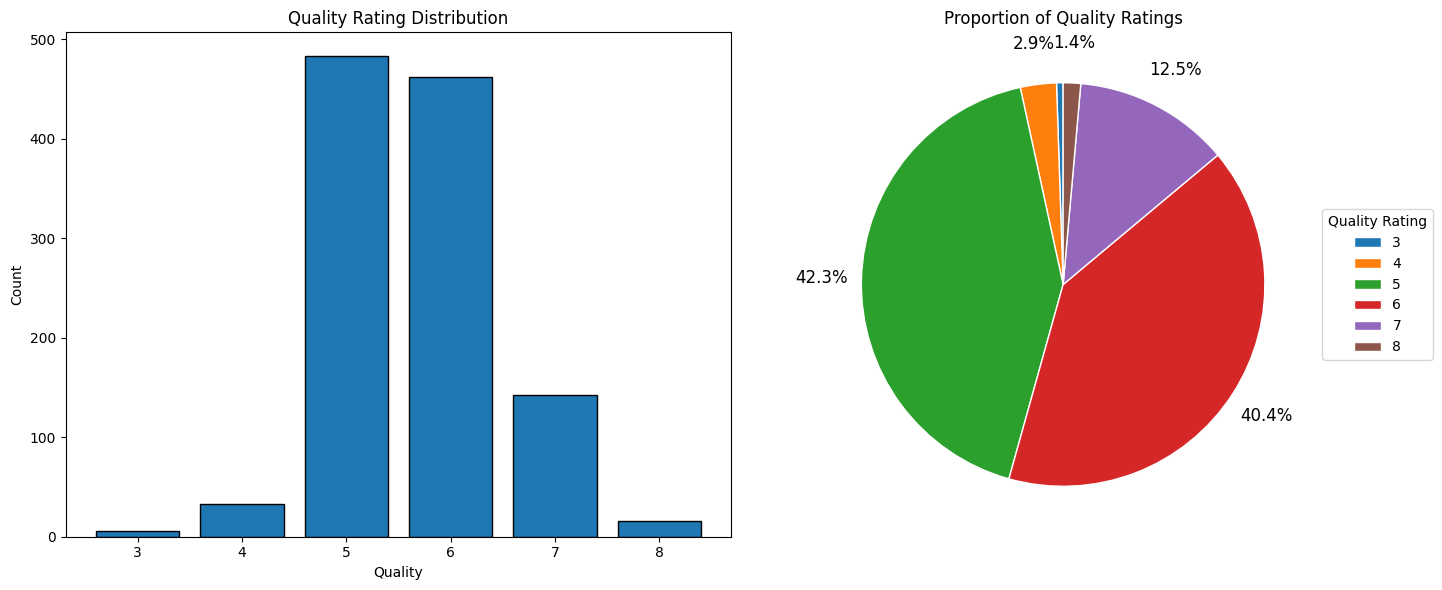

In [22]:
# =============================
# QUALITY DISTRIBUTION (BAR + PIE)
# =============================
plt.figure(figsize=(15, 6))

# Bar chart
plt.subplot(1, 2, 1)
quality_counts = df['quality'].value_counts().sort_index()
plt.bar(quality_counts.index, quality_counts.values, edgecolor='black')
plt.title('Quality Rating Distribution')
plt.xlabel('Quality')
plt.ylabel('Count')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(
    quality_counts,
    autopct=lambda p: f'{p:.1f}%' if p > 1 else '',
    startangle=90,
    pctdistance=1.2,
    labeldistance=1.3,
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.legend(
    quality_counts.index,
    title="Quality Rating",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title('Proportion of Quality Ratings')
plt.tight_layout()
plt.show()

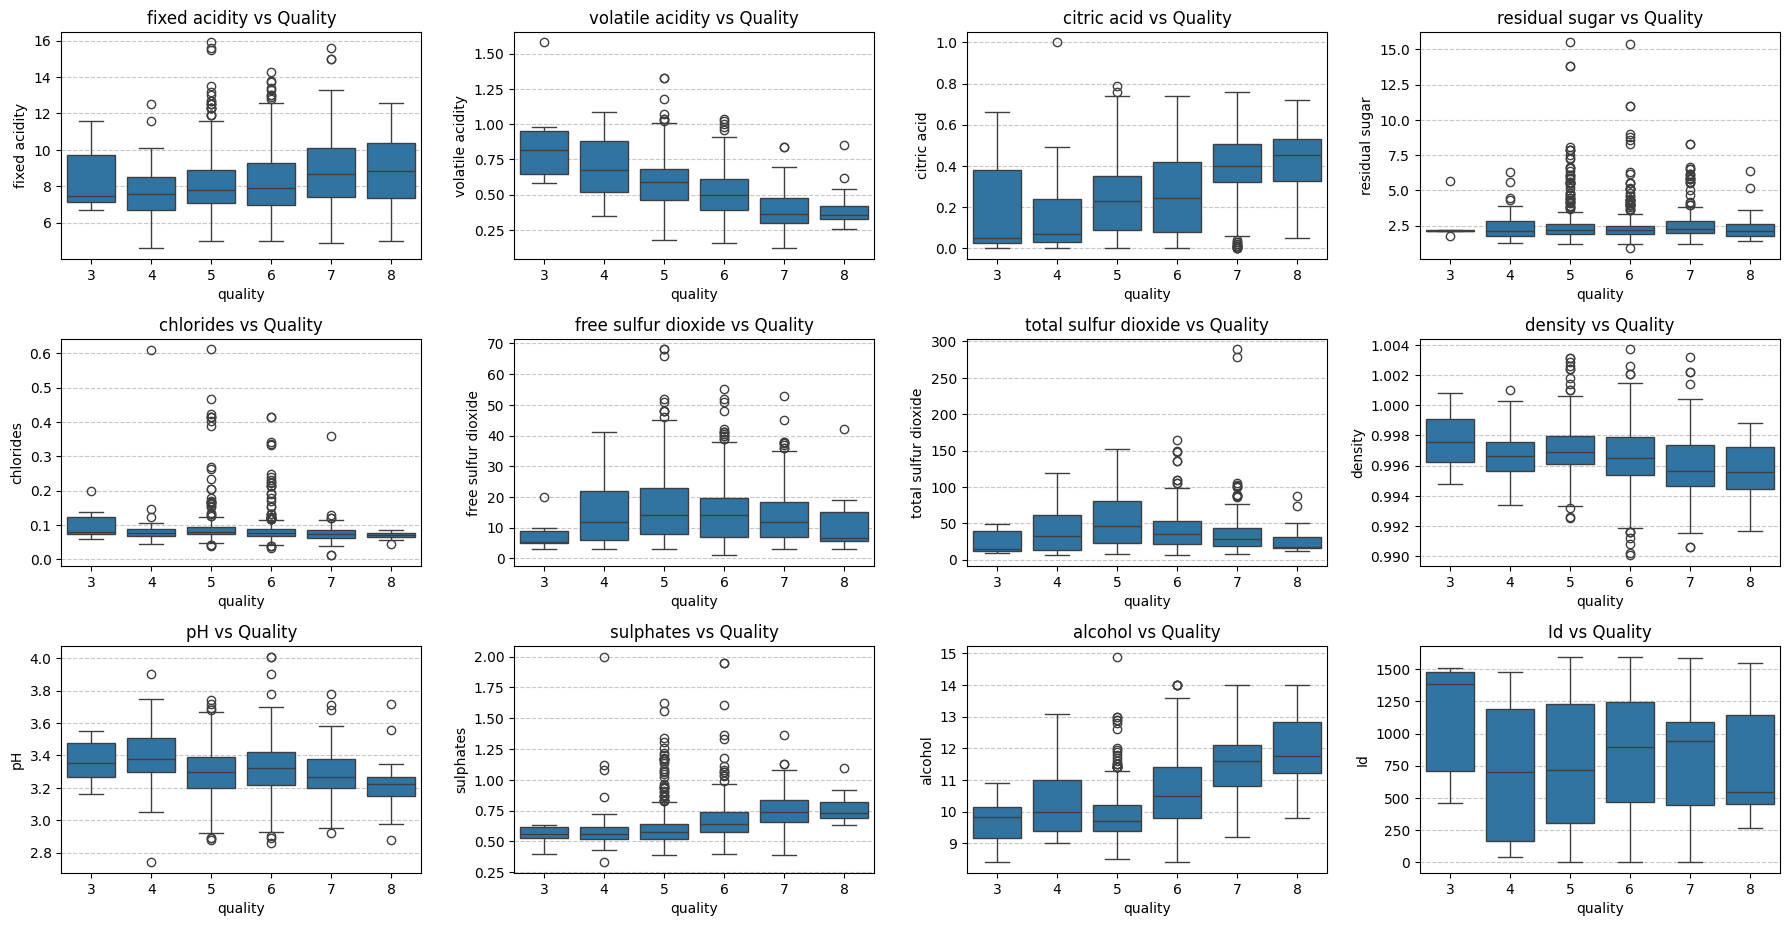

Boxplots showing relationship between features and quality generated.


In [23]:

# =============================
# BOX PLOTS OF FEATURES VS TARGET
# =============================
key_features = df.columns.drop("quality")

plt.figure(figsize=(18, 12))
p = len(key_features)

for i, feature in enumerate(key_features):
    plt.subplot(round(p**0.5) + 1, round(p**0.5) + 1, i + 1)
    sns.boxplot(x=df["quality"], y=df[feature])
    plt.title(f'{feature} vs Quality')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("Boxplots showing relationship between features and quality generated.")


In [24]:
# ---------------------------------------------------------------
# 2. PREPROCESSING (QUALITY BINARIZATION)
# ---------------------------------------------------------------

print("\n--- 2. PREPROCESSING ---")

# Convert quality → binary classes
bins = (2, 6.5, 8)
labels = ['Bad', 'Good']
data['quality'] = pd.cut(data['quality'], bins=bins, labels=labels)

lc = LabelEncoder()
data['quality'] = lc.fit_transform(data['quality'])

X = data.drop('quality', axis=1)
y = data['quality']



--- 2. PREPROCESSING ---



Top 5 Feature Importances:
alcohol             0.149872
volatile acidity    0.103613
citric acid         0.098950
sulphates           0.098572
density             0.087003
dtype: float64


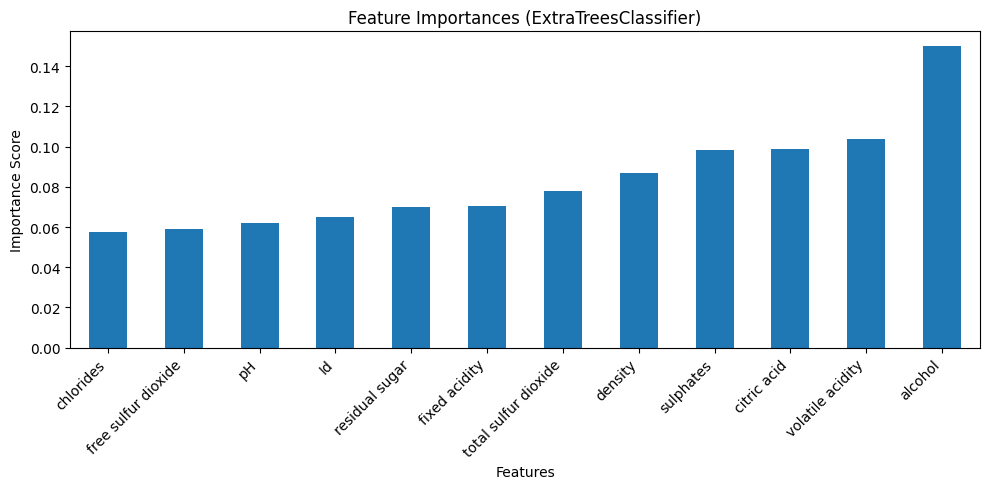

In [25]:
# ---------------------------------------------------------------
# 2C. FEATURE IMPORTANCE (EXTRATREES)
# ---------------------------------------------------------------

extra = ExtraTreesClassifier(random_state=42)
extra_feat = extra.fit(X, y)
ex_data = pd.Series(extra_feat.feature_importances_, index=X.columns)

print("\nTop 5 Feature Importances:")
print(ex_data.nlargest(5))

# Feature importance plot
plt.figure(figsize=(10,5))
ex_data.sort_values().plot(kind='bar')
plt.title("Feature Importances (ExtraTreesClassifier)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
# ---------------------------------------------------------------
# 2D. TRAIN–TEST SPLIT & STANDARDIZATION
# ---------------------------------------------------------------

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [27]:
# ---------------------------------------------------------------
# 3. BASELINE MODELS
# ---------------------------------------------------------------

print("\n--- 3. BASELINE MODELS ---")

models = [
    ("Logistic Regression", LogisticRegression(random_state=42, solver='liblinear')),
    ("KNN", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("SVC", SVC(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
]

baseline_results = []

for name, model in models:
    print(f"\nTraining {name}...")

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    baseline_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Good': report['1']['f1-score']
    })

    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

baseline_df = pd.DataFrame(baseline_results).sort_values(by="F1-Good", ascending=False)
print("\nBASELINE SUMMARY:\n", baseline_df)


--- 3. BASELINE MODELS ---

Training Logistic Regression...
Accuracy: 0.8690
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       197
           1       0.55      0.34      0.42        32

    accuracy                           0.87       229
   macro avg       0.72      0.65      0.67       229
weighted avg       0.85      0.87      0.86       229


Training KNN...
Accuracy: 0.8690
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       197
           1       0.54      0.41      0.46        32

    accuracy                           0.87       229
   macro avg       0.72      0.68      0.69       229
weighted avg       0.86      0.87      0.86       229


Training Decision Tree...
Accuracy: 0.8690
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       197
           1       0.53      0.62      0.57        32

    accuracy              

In [28]:
# ---------------------------------------------------------------
# 4. HYPERPARAMETER TUNING
# ---------------------------------------------------------------

print("\n--- 4. HYPERPARAMETER TUNING (RandomizedSearchCV) ---")

TUNING_SCORING = "f1"
N_ITER_SEARCH = 15
CV_FOLDS = 5

models_to_tune = [

    ("Logistic Regression", LogisticRegression(random_state=42, solver="liblinear"), {
        "C": np.logspace(-3, 2, 10),
        "penalty": ["l1", "l2"]
    }),

    ("KNN", KNeighborsClassifier(), {
        "n_neighbors": np.arange(1, 25),
        "weights": ["uniform", "distance"]
    }),

    ("Decision Tree", DecisionTreeClassifier(random_state=42), {
        "max_depth": np.arange(2, 15),
        "min_samples_split": np.arange(2, 10),
        "min_samples_leaf": np.arange(1, 5)
    }),

    ("SVC", SVC(random_state=42), {
        "C": np.logspace(-1, 2, 10),
        "gamma": np.logspace(-3, 0, 10)
    }),

    ("Random Forest", RandomForestClassifier(random_state=42), {
        "n_estimators": [200, 300, 500],
        "max_depth": [5, 10, 20, None],
        "min_samples_leaf": [1, 2, 4]
    }),

    ("Gradient Boosting", GradientBoostingClassifier(random_state=42), {
        "n_estimators": [200, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 8]
    }),
]

tuned_results = []
tuned_models = []

for name, model, grid in models_to_tune:

    print(f"\n🔍 Tuning {name}...")

    search = RandomizedSearchCV(
        model,
        grid,
        n_iter=N_ITER_SEARCH,
        cv=CV_FOLDS,
        scoring=TUNING_SCORING,
        random_state=42,
        n_jobs=-1
    )

    search.fit(x_train, y_train)
    best = search.best_estimator_

    tuned_models.append((name, best))
    print(f"Best params: {search.best_params_}")


--- 4. HYPERPARAMETER TUNING (RandomizedSearchCV) ---

🔍 Tuning Logistic Regression...
Best params: {'penalty': 'l2', 'C': np.float64(0.001)}

🔍 Tuning KNN...
Best params: {'weights': 'distance', 'n_neighbors': np.int64(13)}

🔍 Tuning Decision Tree...
Best params: {'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(1), 'max_depth': np.int64(10)}

🔍 Tuning SVC...
Best params: {'gamma': np.float64(0.01), 'C': np.float64(46.41588833612777)}

🔍 Tuning Random Forest...
Best params: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': 10}

🔍 Tuning Gradient Boosting...
Best params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}



--- 5. FINAL RESULTS (TUNED MODELS) ---

Evaluating Tuned Logistic Regression...
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       197
           1       0.45      0.44      0.44        32

    accuracy                           0.85       229
   macro avg       0.68      0.68      0.68       229
weighted avg       0.85      0.85      0.85       229

[[180  17]
 [ 18  14]]

Evaluating Tuned KNN...
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       197
           1       0.69      0.56      0.62        32

    accuracy                           0.90       229
   macro avg       0.81      0.76      0.78       229
weighted avg       0.90      0.90      0.90       229

[[189   8]
 [ 14  18]]

Evaluating Tuned Decision Tree...
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       197
           1       0.50      0.56      0.53      

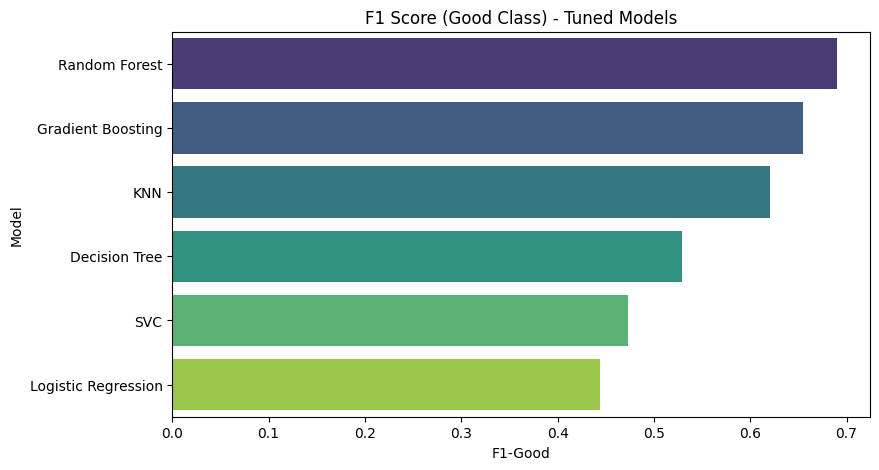


🏆 Best Model: Random Forest  (F1 = 0.6897)


In [29]:

# ---------------------------------------------------------------
# 5. FINAL EVALUATION OF TUNED MODELS
# ---------------------------------------------------------------

print("\n--- 5. FINAL RESULTS (TUNED MODELS) ---")

for name, model in tuned_models:

    print(f"\nEvaluating Tuned {name}...")
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    tuned_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1-Good": report["1"]["f1-score"]
    })

    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

tuned_df = pd.DataFrame(tuned_results).sort_values(by="F1-Good", ascending=False)
print("\nTUNED MODEL SUMMARY:\n", tuned_df)

# Plot Tuned Model F1 Scores
plt.figure(figsize=(9, 5))
sns.barplot(x="F1-Good", y="Model", data=tuned_df, palette="viridis")
plt.title("F1 Score (Good Class) - Tuned Models")
plt.show()

best_model = tuned_df.iloc[0]
print(f"\n🏆 Best Model: {best_model['Model']}  (F1 = {best_model['F1-Good']:.4f})")
